In [242]:
%cd /om2/vast/cbmm/xboix/src/Robustness

/om2/vast/cbmm/xboix/src/Robustness


In [243]:
experiment_name = "vision"
results_dir = '/vast/robustness/' + experiment_name + '/'

In [244]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("poster")

import matplotlib.pyplot as plt
import pandas as pd
import pickle 
import os 

import numpy as np
import pandas
    
import runs.config_experiments_vision as run
experiment_list = run.config_experiments(results_dir, create_json=False)

4705 config files created


In [245]:
name_attacks = ["bound", "l1_pgd_norm", "l1_fgm_norm", "linf_pgd", "l2_pgd_norm", "linf_fgsm", "l2_fgm_norm"]

In [247]:

list_entries = []
for net in ['ThreeLayer']:#['ThreeLayer', 'CNN']:
    for dataset_id,dataset_name in zip([0,66,67],['MNIST','Fashion', 'CIFAR']):

        #Find an experiment of the dataset_id to get the epsilons
        for idx,_ in enumerate(experiment_list[1:]):
            if experiment_list[idx+1]['data_set'] == dataset_id: 
                break
        
        for attack in name_attacks:

            file_name = results_dir + experiment_list[idx+1]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
            if not os.path.isfile(file_name):
                print("Missing!! " + file_name)
                continue
            with open(file_name, 'rb') as f:
                tmp = pickle.load(f)
                


            for idx_epsilon, cv_epsilon in enumerate(list(tmp.keys())):
                # Hash table of parameters
                parameters = {"epsilon": {}, "standarize": {}, "backbone": {}, "initial_learning_rate": {}, 
                              "robust_training": {}, "type_robust": {}, "epsilon_pgd_training":{}}

                to_exclude = [0]
                experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
                for exp in experiment_list_tmp:
                    if not exp['data_set'] == dataset_id: 
                        continue
                    for kk in parameters.keys():
                        if exp[kk] in parameters[kk]:
                            parameters[kk][exp[kk]].append(int(exp["model_name"]))
                        else:
                            parameters[kk][exp[kk]] = [int(exp["model_name"])]


                # For all methods, do cross-val and create an entry of the results
                backbones = [net, net+"+pgd"]



                for backbone in backbones:
                    for robust_training in [True, False]:
                        if robust_training:
                            type_robust_trainings = ['linf','l1',"certificate",'grad']
                        else:
                            type_robust_trainings = ['none']
                        for type_robust in type_robust_trainings:

                            if (backbone == 'Madry' and robust_training == True) or \
                                (backbone == 'CNN+clipping' and robust_training == False):
                                continue

                            if robust_training==False:
                                ids = list(set(parameters["backbone"][backbone]) & 
                                           set(parameters["robust_training"][False]))
                            else:
                                ids = list(set(parameters["backbone"][backbone]) & 
                                       set(parameters["robust_training"][True])&
                                      set(parameters["type_robust"][type_robust]))



                            if backbone == net + '+pgd' and robust_training == True:
                                continue

                            if ids == []:
                                continue
                            #print(ids)


                            # Cross-validation among learning rates and epsilons:
                            best_acc = -1
                            best_id = ids[0]
                            for id in ids:
                                if ((robust_training == False) & (backbone==net) \
                                    & (experiment_list[id]['training_batch_size']==256)):
                                    continue
                                    
                                file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
                                if not os.path.isfile(file_name):
                                    print("Missing!! " + file_name)
                                    continue

                                with open(file_name, 'rb') as f:
                                    tmp_acc = pickle.load(f)

                                acc = list(tmp_acc.values())[idx_epsilon] #tmp_acc[cv_epsilon]
                                if acc>best_acc:
                                    best_id = id
                                    best_acc = acc

                            if best_acc == -1:
                                continue

                            if (robust_training == False) & (backbone==net):  
                                name_legend = 'vanilla'
                            elif backbone== net + '+pgd':
                                name_legend = 'pgd'
                            else:
                                if type_robust=='certificate':
                                    name_legend = 'RUB'
                                elif type_robust=='linf':
                                    name_legend = 'aRUB_Linf'
                                elif type_robust=='grad':
                                    name_legend = 'grad'
                                else:
                                    name_legend = 'aRUB_L1'

                            entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                                     "net": net,
                                     "dataset": dataset_name,
                                     "standarize": experiment_list[best_id]['standarize'],
                                    #"backbone": experiment_list[best_id]['backbone'],
                                    "robust_training": name_legend,
                                    "epsilon": experiment_list[best_id]['epsilon'],
                                    "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training']}

                            dataset = "test"
                            entry["attack"] = attack
                            entry["experiment_id"] = best_id

                            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                                attack + '.pkl', 'rb') as f:
                                tmp_acc = pickle.load(f)

                            entry["accuracy"] =  100*(list(tmp_acc.values())[idx_epsilon]) #tmp_acc[cv_epsilon]
                            entry["test_epsilon"] = cv_epsilon
                            
                            ''' 
                            if not net == 'Madry':
                                with open(results_dir + experiment_list[best_id]['model_name'] + 
                                              '/results/training_time.pkl', 'rb') as f:
                                    tmp = pickle.load(f)
                                    entry["images_per_second"] = np.mean(tmp) 
                                    entry["std_images_per_second"] = np.std(tmp) 
                            '''
                            #with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + 'test' + '_' + 
                            #        'bound' + '.pkl', 'rb') as f:
                            #    tmp = pickle.load(f)
                            #if type_robust == 'certificate':
                            #    print(tmp)
                            #entry["bound"] =  100*tmp[cv_epsilon]
                            list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 


In [248]:
df = pd.concat([df_results, df_results2], ignore_index=True)

In [238]:
df

,learning_rate,net,dataset,standarize,robust_training,epsilon,epsilon_pgd_training,attack,experiment_id,accuracy,test_epsilon
0,0.00100,ThreeLayer,MNIST,False,aRUB_Linf,0.0100,0.1,bound,2396,98.398438,0.000000
1,0.00100,ThreeLayer,MNIST,False,aRUB_L1,0.1000,0.1,bound,2474,98.515625,0.000000
2,0.00100,ThreeLayer,MNIST,False,RUB,0.0010,0.1,bound,2703,98.007812,0.000000
3,0.00100,ThreeLayer,MNIST,False,grad,0.3000,0.1,bound,2552,98.046875,0.000000
4,0.00100,ThreeLayer,MNIST,False,vanilla,0.1000,0.1,bound,4,97.734375,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2605,0.00010,ThreeLayer,CIFAR,False,aRUB_L1,10.0000,0.1,l2_fgm_norm,923,19.062500,2771.281292
2606,1.00000,ThreeLayer,CIFAR,True,RUB,0.0001,0.1,l2_fgm_norm,4628,9.687500,2771.281292
2607,0.01000,ThreeLayer,CIFAR,True,grad,0.0001,0.1,l2_fgm_norm,2144,9.062500,2771.281292
2608,0.01000,ThreeLayer,CIFAR,True,vanilla,0.1000,0.1,l2_fgm_norm,1963,9.062500,2771.281292


In [71]:
experiment_list[4658]

{'_comment': '=====ADVERSARIAL EXAMPLES CONFIGURATION=====',
 'model_name': '4658',
 'restart': False,
 'skip': False,
 'data_set': 67,
 'backbone': 'ThreeLayer',
 'l1_size': 200,
 'l2_size': 200,
 'random_seed': 4557077,
 'robust_training': True,
 'max_num_training_steps': 10000,
 'num_output_steps': 500,
 'training_size': 50000,
 'training_batch_size': 256,
 'initial_learning_rate': 0.01,
 'batch_decrease_learning_rate': 10000000000.0,
 'eval_attack_during_training': False,
 'epsilon': 3,
 'increasing_epsilon': False,
 'type_robust': 'certificate',
 'bound_upper': 100000000000.0,
 'bound_lower': -100000000000.0,
 'standarize': True,
 'standarize_multiplier': 255.0,
 're_size': 1,
 'pgd_training': False,
 'epsilon_pgd_training': 0.1}

In [36]:
tmp_acc

{0.0: 0.099609375,
 0.011085125168440815: 0.099609375,
 0.027712812921102035: 0.09921875,
 0.04434050067376326: 0.09921875,
 0.05542562584220407: 0.098828125,
 0.08313843876330611: 0.098828125,
 0.11085125168440814: 0.098828125,
 0.16627687752661222: 0.098828125,
 0.5542562584220407: 0.0984375,
 5.542562584220407: 0.134375,
 16.62768775266122: 0.133984375,
 27.712812921102035: 0.134375,
 55.42562584220407: 0.156640625}

In [252]:
df.to_csv('vision_new.csv', index=False)

In [105]:
df_results[((df_results.attack == 'bound') | (df_results.attack == 'l1_pgd_norm'))
           & (df_results.test_epsilon == 14)]



,learning_rate,net,dataset,standarize,robust_training,epsilon,epsilon_pgd_training,attack,experiment_id,accuracy,test_epsilon
66,0.0010,ThreeLayer,MNIST,True,aRUB_Linf,0.10,0.1,l1_pgd_norm,3573,97.109375,14.0
67,0.0010,ThreeLayer,MNIST,True,aRUB_L1,0.10,0.1,l1_pgd_norm,3650,96.523438,14.0
68,0.0100,ThreeLayer,MNIST,True,RUB,0.30,0.1,l1_pgd_norm,3871,96.250000,14.0
69,0.0010,ThreeLayer,MNIST,True,grad,0.01,0.1,l1_pgd_norm,3726,95.546875,14.0
70,0.0010,ThreeLayer,MNIST,True,vanilla,0.10,0.1,l1_pgd_norm,1180,94.492188,14.0
71,0.0010,ThreeLayer,MNIST,True,pgd,10.00,0.1,l1_pgd_norm,3804,97.304688,14.0
534,0.0001,ThreeLayer,Fashion,True,aRUB_Linf,0.01,0.1,l1_pgd_norm,1623,81.406250,14.0
535,0.0010,ThreeLayer,Fashion,True,aRUB_L1,0.30,0.1,l1_pgd_norm,4043,84.335938,14.0
536,0.0100,ThreeLayer,Fashion,True,RUB,0.30,0.1,l1_pgd_norm,4263,84.179688,14.0
537,0.0010,ThreeLayer,Fashion,True,grad,0.50,0.1,l1_pgd_norm,1769,80.234375,14.0


In [251]:
def bold_extreme_values(data, format_string="%.2f", max_=True):
    if max_:
        extrema = data != data.max()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 


for dd in ["MNIST","Fashion","CIFAR"]:
    ''' 
    ss = df_results[(df_results.dataset==dd)&(df_results.net == 'ThreeLayer')&(df_results.attack == 'bound')].pivot(index=['robust_training'], columns=['test_epsilon'], values=['accuracy'])
    for col in ss.columns.get_level_values(0).unique():
        ss[col] = ss[col].apply(lambda data : bold_extreme_values(data),axis=0)

    print(dd)
    with pd.option_context('display.max_rows', None,
               'display.max_columns', None,
               'display.precision', 1,
               ):
        display(ss)
    '''
        
    ss = df[(df.dataset==dd)&(df.net == 'ThreeLayer')&(df.attack == 'bound')].pivot(index=['robust_training'], columns=['test_epsilon'], values=['accuracy'])
    for col in ss.columns.get_level_values(0).unique():
        ss[col] = ss[col].apply(lambda data : bold_extreme_values(data),axis=0)

    print(dd)
    with pd.option_context('display.max_rows', None,
               'display.max_columns', None,
               'display.precision', 1,
               ):
        display(ss)


MNIST


accuracy                                  \
test_epsilon            0.0e+00         2.0e-04         5.0e-04   
robust_training                                                   
RUB                       98.01           98.01           98.01   
aRUB_L1          \textbf{98.52}  \textbf{98.52}  \textbf{98.52}   
aRUB_Linf                 98.40           98.40           98.40   
grad                      98.05           98.05           98.05   
pgd                       98.48           98.48           98.48   
vanilla                   97.73           97.73           97.73   

                                                                 \
test_epsilon            8.0e-04         1.0e-03         1.5e-03   
robust_training                                                   
RUB                       98.01           98.01           98.01   
aRUB_L1          \textbf{98.52}  \textbf{98.52}  \textbf{98.52}   
aRUB_Linf                 98.40           98.40           98.40   
grad                      98.05           98.05           98.05   
pgd                       98.48           98.48           98.48   
vanilla                   97.73           97.73           97.73   

                                                                 \
test_epsilon            2.0e-03         3.0e-03         5.6e-03   
robust_training                                                   
RUB                       98.01           97.97           97.97   
aRUB_L1          \textbf{98.52}  \textbf{98.52}  \textbf{98.52}   
aRUB_Linf                 98.40           98.40           98.40   
grad                      98.05           98.05           98.05   
pgd                       98.48           98.48           98.48   
vanilla                   97.73           97.73           97.73   

                                                                 \
test_epsilon            1.0e-02         1.4e-02         2.2e-02   
robust_training                                                   
RUB                       97.93           97.93           97.93   
aRUB_L1          \textbf{98.48}  \textbf{98.48}  \textbf{98.48}   
aRUB_Linf                 98.40           98.40           98.32   
grad                      98.05           98.05           98.05   
pgd              \textbf{98.48}  \textbf{98.48}           98.44   
vanilla                   97.73           97.73           97.70   

                                                                 \
test_epsilon            2.8e-02         4.2e-02         5.6e-02   
robust_training                                                   
RUB                       97.93           97.93           97.93   
aRUB_L1          \textbf{98.48}  \textbf{98.48}  \textbf{98.48}   
aRUB_Linf                 98.32           98.28           98.28   
grad                      98.05           98.05           98.05   
pgd                       98.44           98.44           98.44   
vanilla                   97.66           97.66           97.58   

                                                                 \
test_epsilon            8.4e-02         1.0e-01         2.8e-01   
robust_training                                                   
RUB                       97.93           97.85           97.46   
aRUB_L1          \textbf{98.48}  \textbf{98.44}           98.20   
aRUB_Linf                 98.20           98.16           97.54   
grad                      98.05           97.58           97.81   
pgd                       98.44           98.40  \textbf{98.36}   
vanilla                   97.42           97.34           97.54   

                                                                 \
test_epsilon            3.0e-01         5.0e-01         1.0e+00   
robust_training                                                   
RUB                       97.46           97.42           97.30   
aRUB_L1                   98.16           98.01           97.73   
aRUB_Linf                 97.50           97.19           97.85 

Fashion


accuracy                                  \
test_epsilon            0.0e+00         2.0e-04         5.0e-04   
robust_training                                                   
RUB                       90.27           90.27           90.27   
aRUB_L1          \textbf{90.51}  \textbf{90.51}  \textbf{90.51}   
aRUB_Linf                 89.96           89.96           89.96   
grad                      89.49           89.49           89.49   
pgd                       89.92           89.92           89.92   
vanilla                   88.59           88.59           88.59   

                                                                 \
test_epsilon            8.0e-04         1.0e-03         1.5e-03   
robust_training                                                   
RUB                       90.23           90.23           90.23   
aRUB_L1          \textbf{90.51}  \textbf{90.51}  \textbf{90.51}   
aRUB_Linf                 89.96           89.96           89.96   
grad                      89.49           89.49           89.49   
pgd                       89.88           89.88           89.88   
vanilla                   88.59           88.59           88.59   

                                                                 \
test_epsilon            2.0e-03         3.0e-03         5.6e-03   
robust_training                                                   
RUB                       90.20           90.20           90.20   
aRUB_L1          \textbf{90.51}  \textbf{90.51}  \textbf{90.51}   
aRUB_Linf                 89.96           89.96           89.96   
grad                      89.49           89.49           89.49   
pgd                       89.84           89.84           89.80   
vanilla                   88.59           88.59           88.59   

                                                                 \
test_epsilon            1.0e-02         1.4e-02         2.2e-02   
robust_training                                                   
RUB                       90.16           90.16           90.43   
aRUB_L1          \textbf{90.51}           90.51           90.43   
aRUB_Linf                 89.96           89.92           89.92   
grad                      90.31           89.38           89.34   
pgd                       89.77  \textbf{90.74}  \textbf{90.74}   
vanilla                   88.55           88.55           88.55   

                                                                 \
test_epsilon            2.8e-02         4.2e-02         5.6e-02   
robust_training                                                   
RUB                       90.43           90.43           90.35   
aRUB_L1                   90.43           90.43           90.39   
aRUB_Linf                 89.92           89.84           89.84   
grad                      89.30           89.45           90.16   
pgd              \textbf{90.62}  \textbf{90.59}  \textbf{90.47}   
vanilla                   88.55           88.52           88.48   

                                                                 \
test_epsilon            8.4e-02         1.0e-01         2.8e-01   
robust_training                                                   
RUB                       90.23           90.16           89.49   
aRUB_L1          \textbf{90.31}  \textbf{90.23}  \textbf{89.73}   
aRUB_Linf                 89.80           89.69           88.75   
grad                      90.16           90.16           87.50   
pgd                       90.12           90.12           87.85   
vanilla                   88.48           88.48           87.93   

                                                                 \
test_epsilon            3.0e-01         5.0e-01         1.0e+00   
robust_training                                                   
RUB              \textbf{89.96}  \textbf{89.77}  \textbf{88.95}   
aRUB_L1                   89.73           88.75           87.07   
aRUB_Linf                 88.63           87.73           86.05 

CIFAR


accuracy                                  \
test_epsilon            0.0e+00         2.0e-04         5.0e-04   
robust_training                                                   
RUB                       50.62           50.62           50.62   
aRUB_L1                   53.40           53.40           53.40   
aRUB_Linf                 53.67           53.63           53.63   
grad                      53.32           53.32           53.32   
pgd              \textbf{54.88}  \textbf{54.88}  \textbf{54.88}   
vanilla                   46.88           46.88           46.88   

                                                                 \
test_epsilon            8.0e-04         1.0e-03         1.5e-03   
robust_training                                                   
RUB                       50.62           50.62           50.62   
aRUB_L1                   53.40           53.36           53.36   
aRUB_Linf                 53.63           53.63           53.63   
grad                      53.32           53.32           53.28   
pgd              \textbf{54.88}  \textbf{54.88}  \textbf{54.88}   
vanilla                   46.88           46.88           46.88   

                                                                 \
test_epsilon            2.0e-03         3.0e-03         1.0e-02   
robust_training                                                   
RUB                       50.62           50.62           50.62   
aRUB_L1                   53.32           53.28           53.16   
aRUB_Linf                 53.63           53.63           53.52   
grad                      53.28           53.28           53.24   
pgd              \textbf{54.88}  \textbf{54.88}  \textbf{54.80}   
vanilla                   46.88           46.88           46.88   

                                                                 \
test_epsilon            1.1e-02         2.8e-02         4.4e-02   
robust_training                                                   
RUB                       50.62           50.43           50.27   
aRUB_L1                   53.16           52.03           51.99   
aRUB_Linf                 53.52           53.40           53.28   
grad                      53.24           51.99           51.88   
pgd              \textbf{54.80}  \textbf{54.30}  \textbf{54.14}   
vanilla                   46.88           46.88           46.84   

                                                                 \
test_epsilon            5.5e-02         8.3e-02         1.0e-01   
robust_training                                                   
RUB                       49.96           47.42           47.23   
aRUB_L1                   51.99           51.95           51.95   
aRUB_Linf                 53.20           53.16           53.09   
grad                      52.66           52.23           51.48   
pgd              \textbf{53.98}  \textbf{53.75}  \textbf{53.91}   
vanilla                   46.76           46.68           46.64   

                                                                 \
test_epsilon            1.1e-01         1.7e-01         3.0e-01   
robust_training                                                   
RUB                       47.23           46.88           49.02   
aRUB_L1                   51.95           51.88  \textbf{51.52}   
aRUB_Linf                 52.93           52.42           50.78   
grad                      52.27           51.56           50.35   
pgd              \textbf{53.44}  \textbf{53.09}           51.41   
vanilla                   46.64           46.37           45.66   

                                                                 \
test_epsilon            5.0e-01         5.5e-01         1.0e+00   
robust_training                                                   
RUB                       48.91           48.91           48.67   
aRUB_L1          \textbf{51.37}  \textbf{51.33}  \textbf{50.43}   
aRUB_Linf                 47.15           47.07           45.98 

In [28]:
def bold_extreme_values(data, format_string="%.2f", max_=True):
    if max_:
        extrema = data != data.max()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

for col in ss.columns.get_level_values(0).unique():
    ss[col] = ss[col].apply(lambda data : bold_extreme_values(data),axis=0)




In [30]:
print(ss)

                       accuracy                                  \
test_epsilon             0.0000          0.0002          0.0005   
robust_training                                                   
RUB                       98.12           98.12           98.12   
aRUB_L1                   97.97           97.97           97.97   
aRUB_Linf        \textbf{98.63}  \textbf{98.59}  \textbf{98.59}   
pgd                       98.55           98.55           98.55   
vanilla                   97.73           97.70           97.66   

                                                                 \
test_epsilon             0.0008          0.0010          0.0015   
robust_training                                                   
RUB                       98.12           98.12           98.12   
aRUB_L1                   97.97           97.97           97.97   
aRUB_Linf        \textbf{98.59}  \textbf{98.59}  \textbf{98.59}   
pgd                       98.55           98.55           98.

In [12]:
print(ss.to_latex(index=True, bold_rows= False,escape=False))  

\begin{tabular}{llllllllllllll}
\toprule
{} & \multicolumn{13}{l}{accuracy} \\
test_epsilon &          0.0000 &          0.0002 &          0.0005 &          0.0008 &          0.0010 &          0.0015 &          0.0020 &          0.0030 &          0.0100 &          0.1000 &          0.3000 &          0.5000 &          1.0000 \\
robust_training &                 &                 &                 &                 &                 &                 &                 &                 &                 &                 &                 &                 &                 \\
\midrule
RUB             &           43.44 &           43.44 &           42.97 &           42.66 &           42.50 &           42.19 &           42.19 &           41.41 &           36.72 &           19.69 &           13.44 &           13.44 &           13.44 \\
aRUB_L1         &  \textbf{50.12} &  \textbf{50.04} &  \textbf{49.88} &  \textbf{49.69} &  \textbf{50.31} &  \textbf{50.08} &  \textbf{50.04} &  \textbf{49.

In [214]:
attack = 'linf_pgd'
df_plot = df_results[(df_results.dataset=='CIFAR') & (df_results.test_epsilon==1.0) & (df_results.attack==attack)]


In [215]:
df_plot

,learning_rate,net,dataset,standarize,robust_training,epsilon,epsilon_pgd_training,attack,experiment_id,accuracy,test_epsilon
1614,0.010,ThreeLayer,CIFAR,True,aRUB_Linf,0.00001,0.1,linf_pgd,1991,11.054688,1.0
1615,0.001,ThreeLayer,CIFAR,False,aRUB_L1,3.00000,0.1,linf_pgd,910,10.117188,1.0
1616,1.000,ThreeLayer,CIFAR,True,RUB,0.00100,0.1,linf_pgd,4630,10.625000,1.0
1617,0.010,ThreeLayer,CIFAR,True,grad,0.00010,0.1,linf_pgd,2144,9.921875,1.0
1618,0.010,ThreeLayer,CIFAR,True,vanilla,0.10000,0.1,linf_pgd,1963,9.921875,1.0
1619,0.100,ThreeLayer,CIFAR,True,pgd,10.00000,0.1,linf_pgd,4566,12.890625,1.0


In [216]:
adv = []
for idx in list(df_plot.experiment_id):
    with open(results_dir + str(idx) + '/results/examples' + attack + '.pkl', 'rb') as f:
            adv += [pickle.load(f)]
            

In [217]:
np.shape(adv[4])


(2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

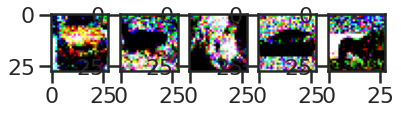

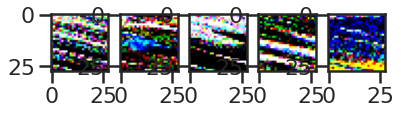

In [225]:
for idx,_ in enumerate(list(df_plot.experiment_id)):
    if len(np.shape(adv[idx]))==4:
        fig = plt.figure()
        for k in range(5):
            fig.add_subplot(1, 5, k+1)
        
            plt.imshow(np.resize(adv[idx][1][-1][k,:],[28,28,3]))

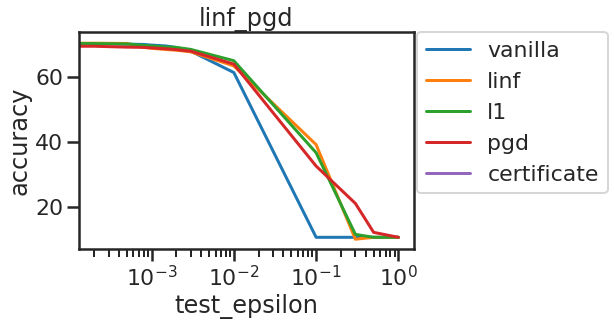

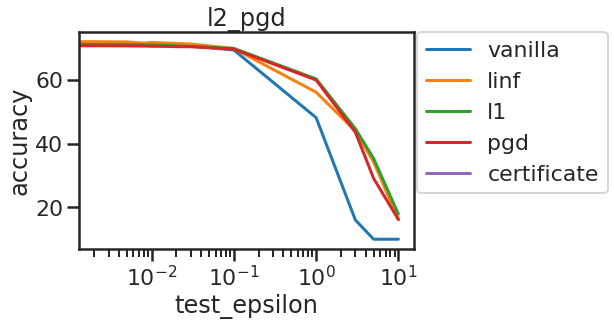

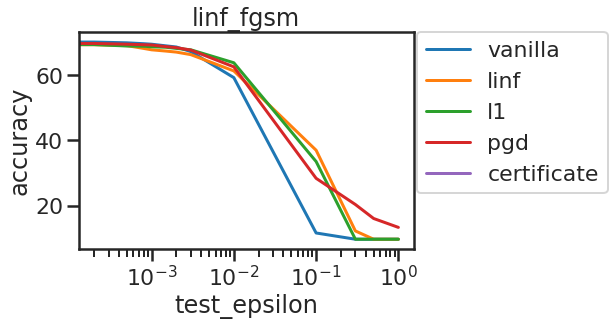

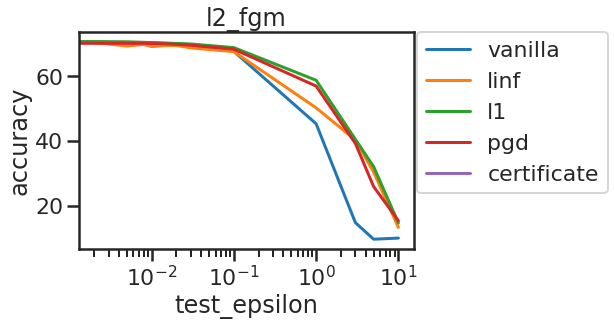

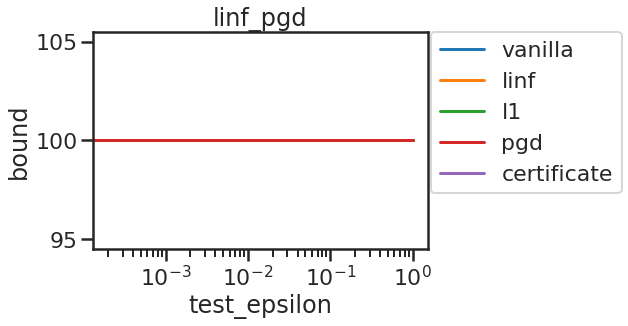

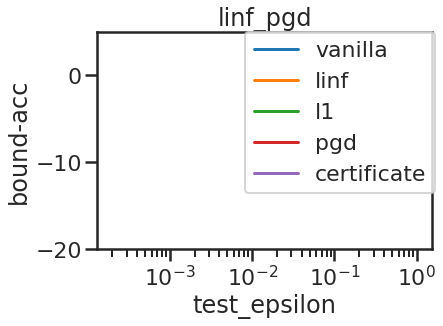

In [81]:
for attack in name_attacks:#[name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="robust_training", hue_order=['vanilla', 'linf', 'l1','pgd','certificate'], palette="tab10",
                 data=df_results[(df_results.attack==attack)]).set_title(attack)
    plt.xscale('log')
    #plt.ylim([0,55])
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="bound",
                 hue="robust_training", hue_order=['vanilla', 'linf', 'l1','pgd','certificate'], palette="tab10",
                 data=df_results[(df_results.attack==attack)]).set_title(attack)
    plt.xscale('log')
    #plt.ylim([0,55])
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    
df_results['bound-acc'] = df_results['bound'] - df_results['accuracy']
for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="bound-acc",
                 hue="robust_training", hue_order=['vanilla', 'linf', 'l1','pgd','certificate'], palette="tab10",
                 data=df_results[(df_results.attack==attack)]).set_title(attack)
    plt.xscale('log')
    plt.ylim([-20,5])
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

[1536, 1543, 1550, 1522, 1529]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


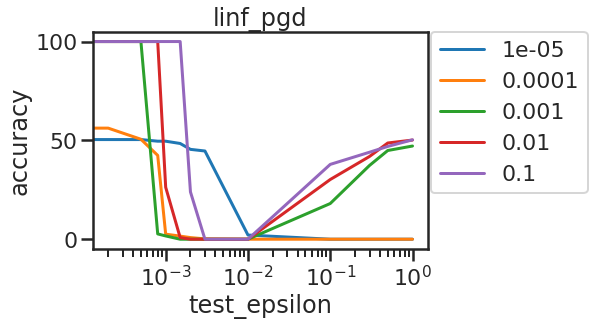

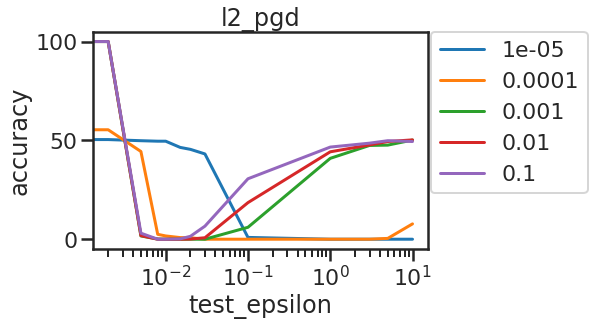

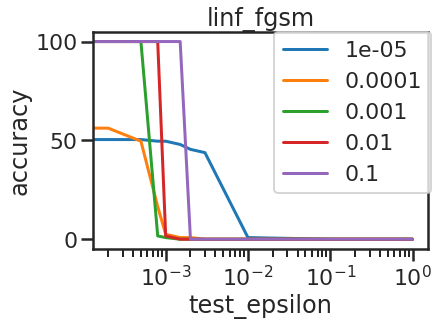

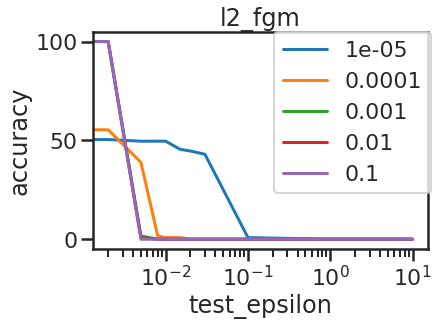

In [44]:
# Display learning rate impact
epsilon = 1e-3
backbone = 'OneLayer'
robust_training = True
epsilon_pgd_training = 0.1
type_robust_training = 'l1'

# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "l1_robustness": {}, "certificate": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:
    if not exp['data_set'] == 26: 
        continue

    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]
                    
if robust_training:
    if type_robust_training=='linf':
        ids = list(set(parameters["backbone"][backbone]) & 
                set(parameters["robust_training"][True])&
                set(parameters["l1_robustness"][False])&
                set(parameters["certificate"][False])&
                set(parameters["epsilon"][epsilon]))
    elif type_robust_training=='l1':
        ids = list(set(parameters["backbone"][backbone]) & 
                set(parameters["robust_training"][True])&
                set(parameters["l1_robustness"][True])&
                set(parameters["certificate"][False])&
                set(parameters["epsilon"][epsilon]))
    elif type_robust_training=='certificate':
        ids = list(set(parameters["backbone"][backbone]) & 
                set(parameters["robust_training"][True])&
                set(parameters["l1_robustness"][True])&
                set(parameters["certificate"][True])&
                set(parameters["epsilon"][epsilon]))
else:
    ids = list(set(parameters["backbone"][backbone]) &
            set(parameters["robust_training"][robust_training]) & 
            set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))

print(ids)
list_entries = []
for id in ids:
    entry = {"learning_rate": experiment_list[id]['initial_learning_rate'],
            "backbone": experiment_list[id]['backbone'],
            "robust_training": experiment_list[id]['robust_training'],
            "epsilon": experiment_list[id]['epsilon']}
 
    for dataset in ["val", "test"]:
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="learning_rate",  palette="tab10",
                 data=df[df.dataset=='test'][df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


In [30]:
# Display epsilon
backbones = ['MLP+pgd']
robust_training = False
epsilon_pgd_training = 1e-3

list_entries = []
for backbone in backbones:
    for epsilon in list(parameters["epsilon"].keys()):

            
        if robust_training:
            ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
                       set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
        else:
            ids = list(set(parameters["backbone"][backbone]) &
                    set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
            
        if len(ids)==0:
            continue
            
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:2]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc
                
        print(best_id)
        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="epsilon",  style='backbone', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


KeyError: 'MLP+pgd'

[1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399]
1376
[1365, 1366, 1367, 1368, 1369]
1366
[1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407]
1408


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


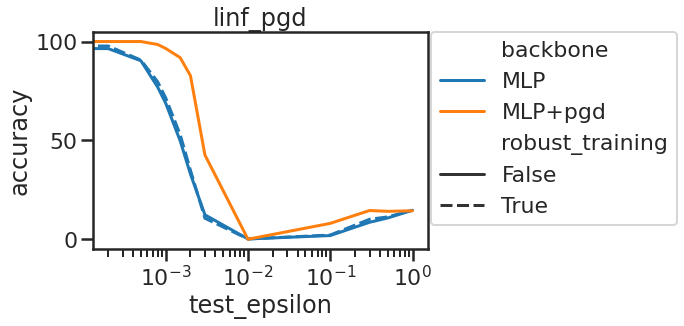

<Figure size 432x288 with 0 Axes>

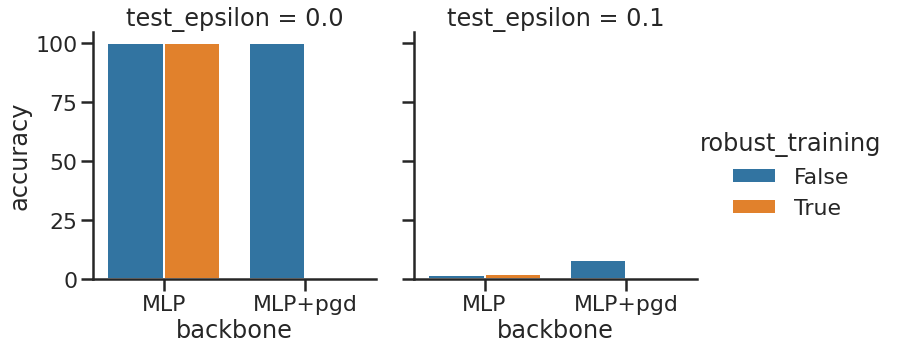

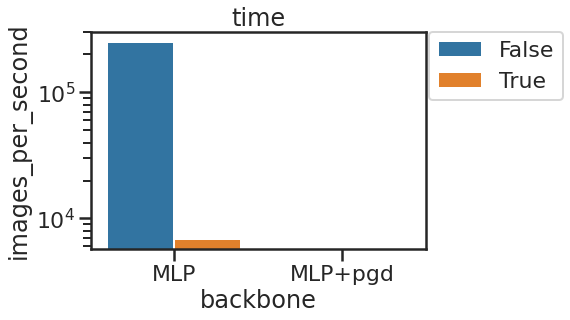

In [60]:
# Display best
backbones = ['MLP', 'MLP+pgd']
robust_trainings = [True,False]

list_entries = []
for backbone in backbones:
    for robust_training in robust_trainings:
        if (backbone == 'Madry' and robust_training == True) or \
            (backbone == 'CNN+clipping' and robust_training == False):
            continue
            
        ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))
        
        if backbone == 'MLP+pgd' and robust_training == True:
            continue
            
        if ids == []:
            continue
        print(ids)
        
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            #if (experiment_list[id]['backbone'] == 'CNN+pgd') and experiment_list[id]["epsilon_pgd_training"] == 0.3:
            #    continue 
            acc = 0.0
            for attack in [name_attacks[0]]:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[0:1]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        print(best_id)
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            
            if not backbone == 'Madry':
                with open(results_dir + experiment_list[best_id]['model_name'] + 
                          '/results/training_time.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                entry["images_per_second"] = np.mean(tmp) 
                entry["std_images_per_second"] = np.std(tmp) 
                
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                  
df = pd.DataFrame.from_dict(list_entries) 

for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    plt.figure()
    epsilon = 0.1
    if attack == "l2_pgd" or attack == "l2_fgm" :
        epsilon = 1
    sns.catplot(x="backbone", y="accuracy",
                 hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                 data=df[(df.test_epsilon == 0)| (df.test_epsilon == epsilon)][df.attack==attack])
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [ ]:
df[(df.test_epsilon==0.01)&(df.attack=='linf_pgd')]

In [87]:
df[df.backbone=="Madry"][df.attack=="linf_pgd"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
218,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN
270,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN


In [107]:
df[df.backbone=="Madry"][df.attack=="linf_fgsm"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
244,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
296,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
